<a href="https://colab.research.google.com/github/kenwkliu/ideas/blob/master/colab/AlternativeData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Alternative Data

In [ ]:
#@title Execute this block to start importing the libraries and helper functions

import math
import pandas as pd

# bypass SSL cert
import os, ssl
if (not os.environ.get('PYTHONHTTPSVERIFY', '') and getattr(ssl, '_create_unverified_context', None)):
  ssl._create_default_https_context = ssl._create_unverified_context

# Enable Google interactive table
from google.colab import data_table
data_table.enable_dataframe_formatter()

# interative map
import folium

# a library to convert the Latitude and Longitude from degree format to decimal
!pip install -q dms2dec
from dms2dec.dms_convert import dms2dec

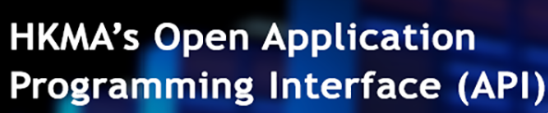

https://apidocs.hkma.gov.hk/

In [ ]:
#@title Get the daily exchange rate from HKMA Open API: <br><h5> https://api.hkma.gov.hk/public/market-data-and-statistics/monthly-statistical-bulletin/er-ir/er-eeri-daily </h5>
url = 'https://api.hkma.gov.hk/public/market-data-and-statistics/monthly-statistical-bulletin/er-ir/er-eeri-daily'

# Read the json URL output into a dataframe
df = pd.read_json(url)

# Extract the record result into another dataframe
ccyDf = pd.DataFrame(df.loc['records', 'result'])
ccyDf.set_index('end_of_day', inplace=True)

# Display the major ccy
ccyDf[['usd', 'gbp', 'cad', 'aud', 'cny', 'jpy', 'eur']]

In [ ]:
#@title Select a ccy to plot the graph

ccy = 'jpy' # @param ["jpy", "gbp", "aud", "eur", "cny", "cad", "usd"] {allow-input: false}

ccyDf[[ccy]].sort_index().plot(figsize = (12, 8))

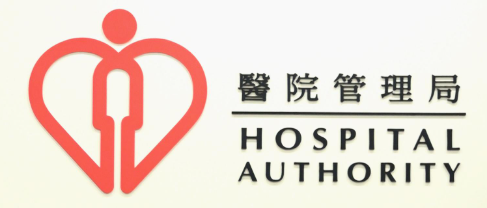

https://www.ha.org.hk/opendata/facility-hosp.json

In [ ]:
#@title Get the Hospitals info from HA Open API
url = 'https://www.ha.org.hk/opendata/facility-hosp.json'
dfHospital = pd.read_json(url)
dfHospital

In [ ]:
#@title Create an interactive map with the hospital info
HK_LAT, HK_LONG = 22.3, 114.2
hmap = folium.Map(location=[HK_LAT, HK_LONG], zoom_start=11)

# From each row of the footbook dataframe, pin the location in the map with the name and opening_time by a tooltip
for row in dfHospital.itertuples():
  tip = row.institution_eng
  #tip = row.institution_tc
  if math.isnan(row.latitude) == False and math.isnan(row.longitude) == False:
    folium.Marker([row.latitude, row.longitude], tooltip=tip).add_to(hmap)

hmap

In [ ]:
#@title Save the hospital map to an html file
hmap.save('hospital.html')